In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
param = pybamm.LithiumIonParameters()
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)
Cn
Cp

5.795692012196613

## Initialize model at full charge to 4.1V

In [6]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
parameter_values.update(
    {
        "Exchange-current density for plating [A.m-2]": 0.001,
        "Initial plated lithium concentration [mol.m-3]": 0,
        "Lithium metal partial molar volume [m3.mol-1]": 1.3e-5,
        "SEI kinetic rate constant [m.s-1]": 1e-15,
        "SEI resistivity [Ohm.m]": 0,
    },
)
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "SEI film resistance": "none",
        "lithium plating": "irreversible",
    }
)

In [7]:
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = spm.param

Vmin = 3.0
Vmax = 4.2
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)

esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
)
print(esoh_sol["x_100"].data[0])
print(esoh_sol["y_100"].data[0])

0.8334162315444247
0.03350230659015566


## One cycle

In [8]:
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": esoh_sol["x_100"].data[0] * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": esoh_sol["y_100"].data[0] * c_p_max,
    }
)
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

In [9]:
spm_sol.plot(["Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=3.148682032825511, step=0.03148682032825511)…

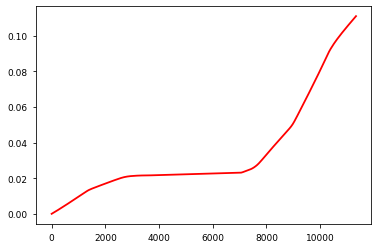

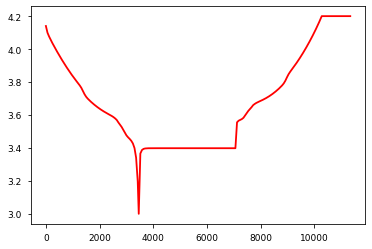

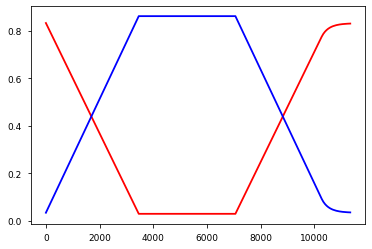

In [10]:
plt.plot(spm_sol["Time [s]"].data, spm_sol["Loss of Lithium Inventory [%]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Terminal voltage [V]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Negative electrode SOC"].data)
plt.plot(spm_sol["Time [s]"].data, spm_sol["Positive electrode SOC"].data)

In [11]:
lli = spm_sol["Loss of Lithium Inventory [%]"].data
lli_one_cycle = lli[-1] - lli[0]

## Several cycles

In [13]:
pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
    f"Charge at 1C until {Vmax}V", 
    f"Hold at {Vmax}V until C/50")
] * 100,
termination="80% capacity"
)
sim_100 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
spm_sol_100 = sim_100.solve()

2021-03-21 20:21:32,378 - [NOTICE] simulation.solve(701): Cycle 1/100 (27.159 ms elapsed) --------------------
2021-03-21 20:21:32,378 - [NOTICE] simulation.solve(731): Cycle 1/100, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:21:32,483 - [NOTICE] simulation.solve(731): Cycle 1/100, step 2/4: Rest for 1 hour
2021-03-21 20:21:32,566 - [NOTICE] simulation.solve(731): Cycle 1/100, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:21:32,664 - [NOTICE] simulation.solve(731): Cycle 1/100, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:21:32,953 - [NOTICE] simulation.solve(807): Capacity is now 4.936 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 20:21:32,953 - [NOTICE] simulation.solve(701): Cycle 2/100 (603.103 ms elapsed) --------------------
2021-03-21 20:21:32,954 - [NOTICE] simulation.solve(731): Cycle 2/100, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:21:33,001 - [NOTICE] simulation.solve(731): Cycle 2/100, step 2/4: Rest for 1 hour
2021-03-21 20:21:33,038 - [NO

2021-03-21 20:21:35,366 - [NOTICE] simulation.solve(731): Cycle 13/100, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:21:35,435 - [NOTICE] simulation.solve(807): Capacity is now 4.869 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 20:21:35,436 - [NOTICE] simulation.solve(701): Cycle 14/100 (3.085 s elapsed) --------------------
2021-03-21 20:21:35,436 - [NOTICE] simulation.solve(731): Cycle 14/100, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:21:35,484 - [NOTICE] simulation.solve(731): Cycle 14/100, step 2/4: Rest for 1 hour
2021-03-21 20:21:35,522 - [NOTICE] simulation.solve(731): Cycle 14/100, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:21:35,563 - [NOTICE] simulation.solve(731): Cycle 14/100, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:21:35,632 - [NOTICE] simulation.solve(807): Capacity is now 4.864 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 20:21:35,632 - [NOTICE] simulation.solve(701): Cycle 15/100 (3.282 s elapsed) --------------------

2021-03-21 20:21:37,863 - [NOTICE] simulation.solve(731): Cycle 26/100, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:21:37,913 - [NOTICE] simulation.solve(731): Cycle 26/100, step 2/4: Rest for 1 hour
2021-03-21 20:21:37,953 - [NOTICE] simulation.solve(731): Cycle 26/100, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:21:37,997 - [NOTICE] simulation.solve(731): Cycle 26/100, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:21:38,076 - [NOTICE] simulation.solve(807): Capacity is now 4.799 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 20:21:38,077 - [NOTICE] simulation.solve(701): Cycle 27/100 (5.727 s elapsed) --------------------
2021-03-21 20:21:38,078 - [NOTICE] simulation.solve(731): Cycle 27/100, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:21:38,140 - [NOTICE] simulation.solve(731): Cycle 27/100, step 2/4: Rest for 1 hour
2021-03-21 20:21:38,179 - [NOTICE] simulation.solve(731): Cycle 27/100, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:21:38,224 - [NOT

2021-03-21 20:21:40,342 - [NOTICE] simulation.solve(731): Cycle 38/100, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:21:40,402 - [NOTICE] simulation.solve(807): Capacity is now 4.735 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 20:21:40,403 - [NOTICE] simulation.solve(701): Cycle 39/100 (8.053 s elapsed) --------------------
2021-03-21 20:21:40,404 - [NOTICE] simulation.solve(731): Cycle 39/100, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:21:40,450 - [NOTICE] simulation.solve(731): Cycle 39/100, step 2/4: Rest for 1 hour
2021-03-21 20:21:40,488 - [NOTICE] simulation.solve(731): Cycle 39/100, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:21:40,528 - [NOTICE] simulation.solve(731): Cycle 39/100, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:21:40,595 - [NOTICE] simulation.solve(807): Capacity is now 4.729 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 20:21:40,595 - [NOTICE] simulation.solve(701): Cycle 40/100 (8.245 s elapsed) --------------------

2021-03-21 20:21:43,046 - [NOTICE] simulation.solve(731): Cycle 51/100, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:21:43,092 - [NOTICE] simulation.solve(731): Cycle 51/100, step 2/4: Rest for 1 hour
2021-03-21 20:21:43,129 - [NOTICE] simulation.solve(731): Cycle 51/100, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:21:43,173 - [NOTICE] simulation.solve(731): Cycle 51/100, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:21:43,241 - [NOTICE] simulation.solve(807): Capacity is now 4.667 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 20:21:43,242 - [NOTICE] simulation.solve(701): Cycle 52/100 (10.892 s elapsed) --------------------
2021-03-21 20:21:43,242 - [NOTICE] simulation.solve(731): Cycle 52/100, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:21:43,288 - [NOTICE] simulation.solve(731): Cycle 52/100, step 2/4: Rest for 1 hour
2021-03-21 20:21:43,326 - [NOTICE] simulation.solve(731): Cycle 52/100, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:21:43,371 - [NO

2021-03-21 20:21:45,526 - [NOTICE] simulation.solve(731): Cycle 63/100, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:21:45,591 - [NOTICE] simulation.solve(807): Capacity is now 4.605 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 20:21:45,591 - [NOTICE] simulation.solve(701): Cycle 64/100 (13.241 s elapsed) --------------------
2021-03-21 20:21:45,592 - [NOTICE] simulation.solve(731): Cycle 64/100, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:21:45,637 - [NOTICE] simulation.solve(731): Cycle 64/100, step 2/4: Rest for 1 hour
2021-03-21 20:21:45,675 - [NOTICE] simulation.solve(731): Cycle 64/100, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:21:45,720 - [NOTICE] simulation.solve(731): Cycle 64/100, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:21:45,795 - [NOTICE] simulation.solve(807): Capacity is now 4.600 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 20:21:45,796 - [NOTICE] simulation.solve(701): Cycle 65/100 (13.446 s elapsed) ------------------

2021-03-21 20:21:48,083 - [NOTICE] simulation.solve(731): Cycle 76/100, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:21:48,128 - [NOTICE] simulation.solve(731): Cycle 76/100, step 2/4: Rest for 1 hour
2021-03-21 20:21:48,167 - [NOTICE] simulation.solve(731): Cycle 76/100, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:21:48,211 - [NOTICE] simulation.solve(731): Cycle 76/100, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:21:48,285 - [NOTICE] simulation.solve(807): Capacity is now 4.540 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 20:21:48,286 - [NOTICE] simulation.solve(701): Cycle 77/100 (15.936 s elapsed) --------------------
2021-03-21 20:21:48,287 - [NOTICE] simulation.solve(731): Cycle 77/100, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:21:48,334 - [NOTICE] simulation.solve(731): Cycle 77/100, step 2/4: Rest for 1 hour
2021-03-21 20:21:48,373 - [NOTICE] simulation.solve(731): Cycle 77/100, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:21:48,427 - [NO

2021-03-21 20:21:50,851 - [NOTICE] simulation.solve(731): Cycle 88/100, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:21:50,924 - [NOTICE] simulation.solve(807): Capacity is now 4.481 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 20:21:50,925 - [NOTICE] simulation.solve(701): Cycle 89/100 (18.575 s elapsed) --------------------
2021-03-21 20:21:50,926 - [NOTICE] simulation.solve(731): Cycle 89/100, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:21:50,973 - [NOTICE] simulation.solve(731): Cycle 89/100, step 2/4: Rest for 1 hour
2021-03-21 20:21:51,013 - [NOTICE] simulation.solve(731): Cycle 89/100, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:21:51,057 - [NOTICE] simulation.solve(731): Cycle 89/100, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:21:51,130 - [NOTICE] simulation.solve(807): Capacity is now 4.476 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 20:21:51,131 - [NOTICE] simulation.solve(701): Cycle 90/100 (18.780 s elapsed) ------------------

In [29]:
spm_sol_100.save("test.sav")

AttributeError: Can't pickle local object 'ProcessedVariable.initialise_0D.<locals>.fun'

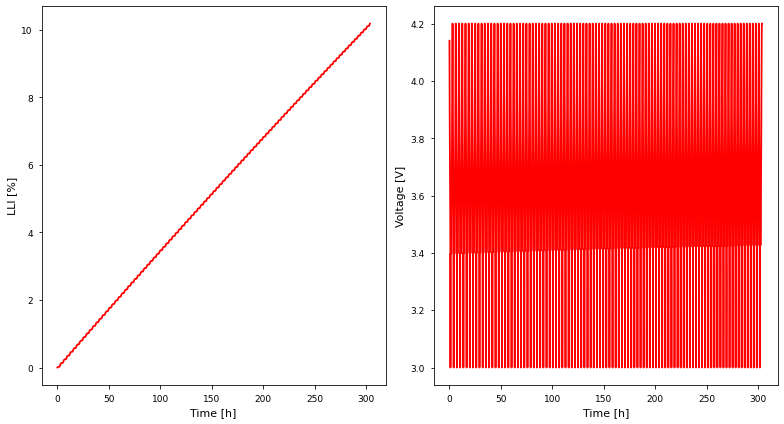

In [15]:
fig, ax = plt.subplots(1,2,figsize=(11,6))

ax[0].plot(spm_sol_100["Time [h]"].data, spm_sol_100["Loss of Lithium Inventory [%]"].data)
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")
ax[1].plot(spm_sol_100["Time [h]"].data, spm_sol_100["Terminal voltage [V]"].data)
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

fig.tight_layout()
OUTPUT_DIR = "/Users/vsulzer/Google Drive/PCL_Sulzer/"
fig.savefig(OUTPUT_DIR + "100_cycles.eps", dpi=1000)

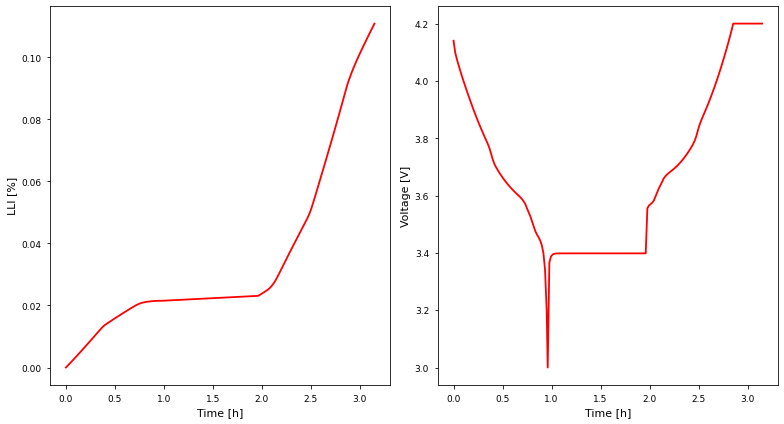

In [16]:
fig, ax = plt.subplots(1,2,figsize=(11,6))

ax[0].plot(spm_sol_100.cycles[0]["Time [h]"].data, spm_sol_100.cycles[0]["Loss of Lithium Inventory [%]"].data)
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")
ax[1].plot(spm_sol_100.cycles[0]["Time [h]"].data, spm_sol_100.cycles[0]["Terminal voltage [V]"].data)
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

fig.tight_layout()
fig.savefig(OUTPUT_DIR + "first_cycle.eps", dpi=1000)

In [17]:
lli_100 = spm_sol_100["Loss of Lithium Inventory [%]"].data
lli_100_cycles = lli_100[-1] - lli_100[0]

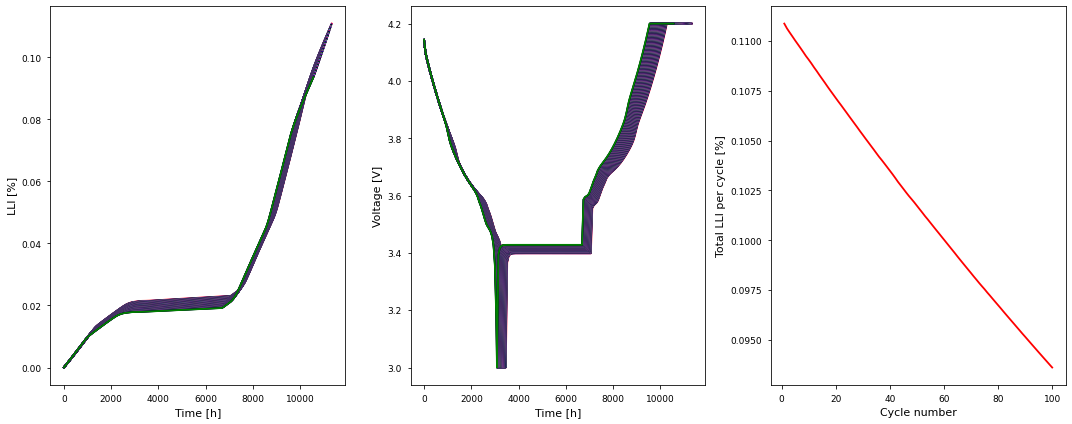

In [18]:

fig, ax = plt.subplots(1,3,figsize=(15,6))

all_lli = []
for cycle in spm_sol_100.cycles:
    t = cycle["Time [s]"].data
    lli = cycle["Loss of Lithium Inventory [%]"].data
    V = cycle["Terminal voltage [V]"].data

    ax[0].plot(t - t[0], lli-lli[0])
    ax[1].plot(t-t[0], V)
    
    all_lli.append(lli[-1]-lli[0])

ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")    
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

ax[2].plot(range(1, len(all_lli)+1), all_lli)
ax[2].set_xlabel("Cycle number")
ax[2].set_ylabel("Total LLI per cycle [%]")

fig.tight_layout()
fig.savefig(OUTPUT_DIR + "cycles_comparison.eps", dpi=1000)

### eSOH parameters


In [19]:
len(spm_sol_100.summary_variables.items())

71

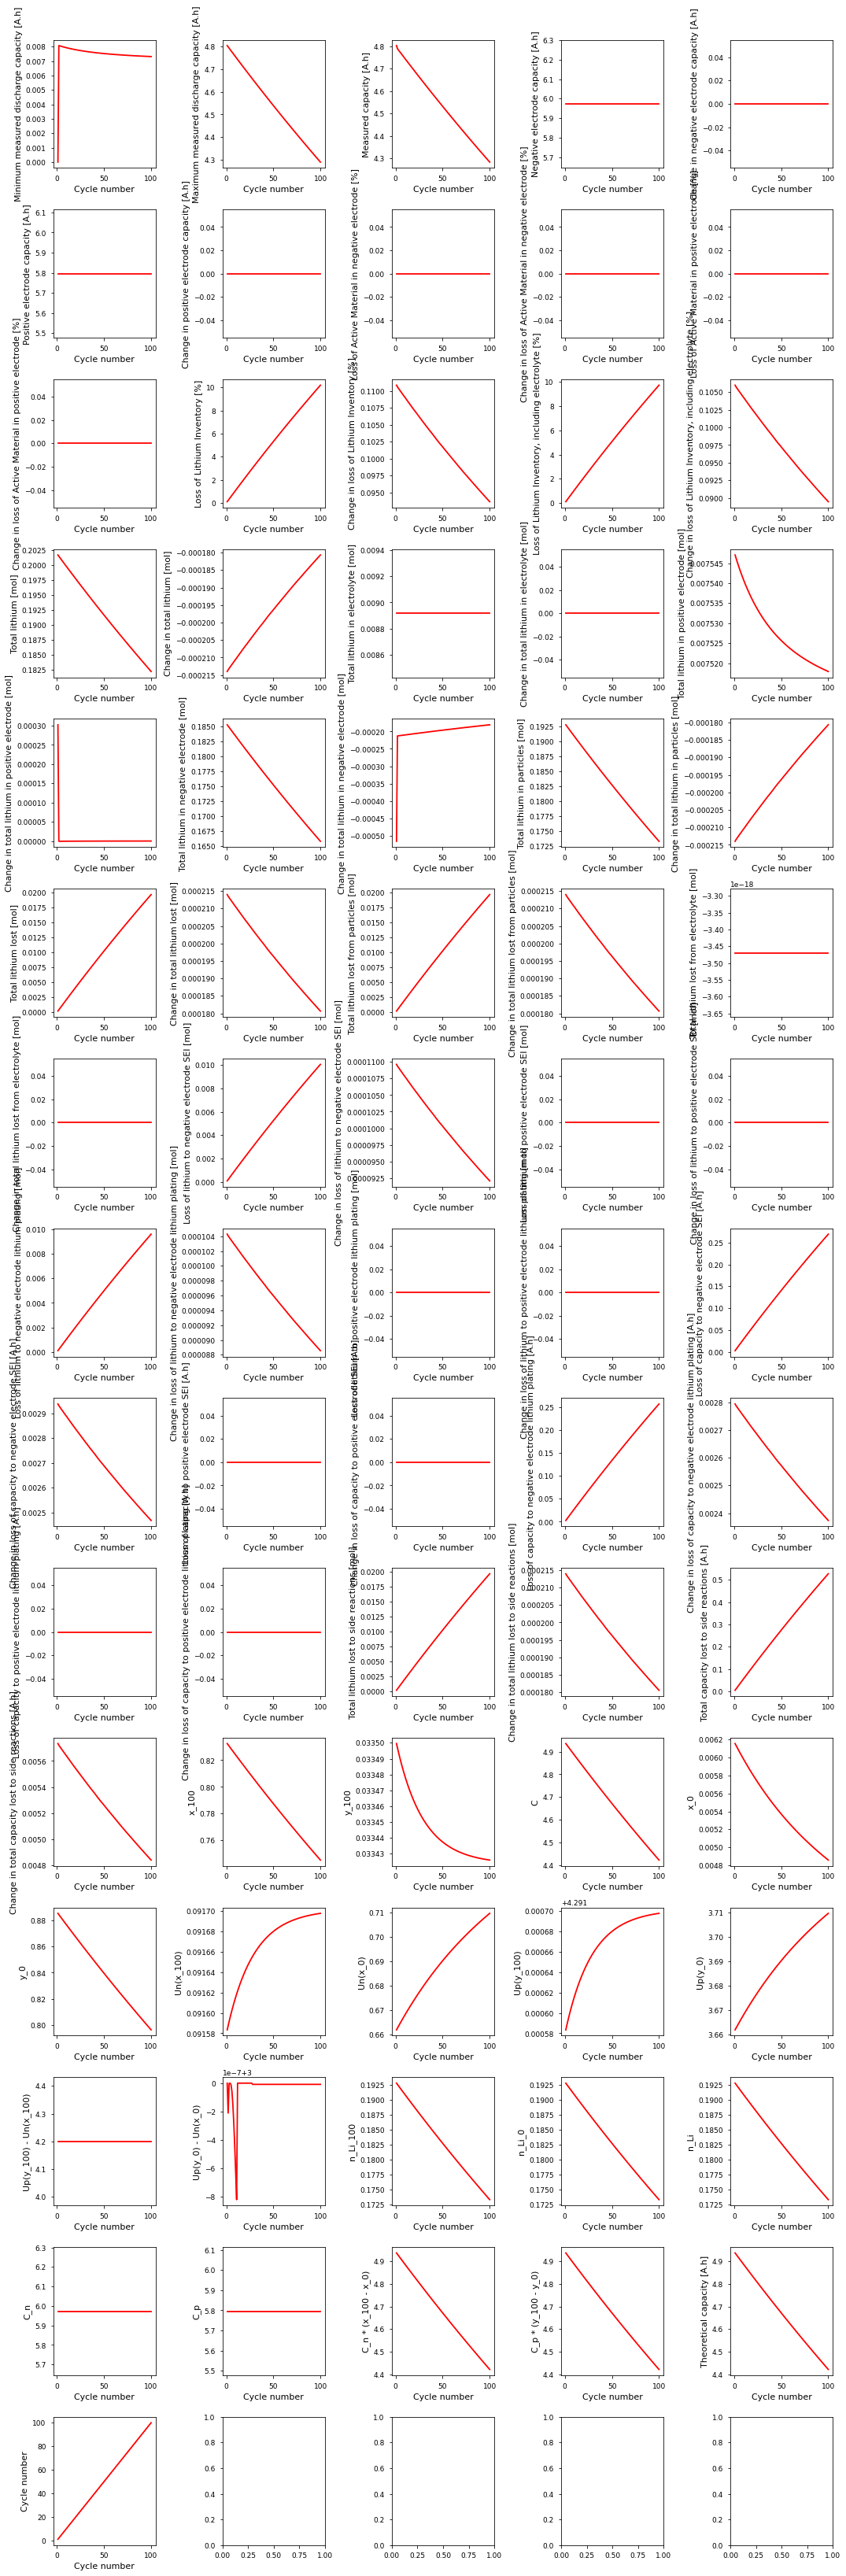

In [20]:
fig, axes = plt.subplots(15,5,figsize=(15,45))

for k, (name,val) in enumerate(spm_sol_100.summary_variables.items()):
    ax = axes.flat[k]
    ax.plot(spm_sol_100.summary_variables["Cycle number"],val)
    ax.set_xlabel("Cycle number")
    ax.set_ylabel(name)

# axes.flat[4].plot(range(1,101), all_nLi)
# axes.flat[4].set_xlabel("Cycle number")
# axes.flat[4].set_ylabel("n_Li")
# axes.flat[-1].plot(range(1,101), all_C)
# axes.flat[-1].set_xlabel("Cycle number")
# axes.flat[-1].set_ylabel("C")
# axes.flat[-1].set_ylim([2,5])
# axes.flat[-2].set_ylim([2,5])

fig.tight_layout()

## Accelerated simulations algorithm

### Constant extrapolation

Solve for 1 cycle

In [21]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

2021-03-21 20:22:35,296 - [NOTICE] simulation.solve(701): Cycle 1/1 (29.551 ms elapsed) --------------------
2021-03-21 20:22:35,296 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:22:35,399 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 20:22:35,485 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:22:35,591 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:22:35,887 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 620.287 ms


Check how well extrapolating 1 cycle does

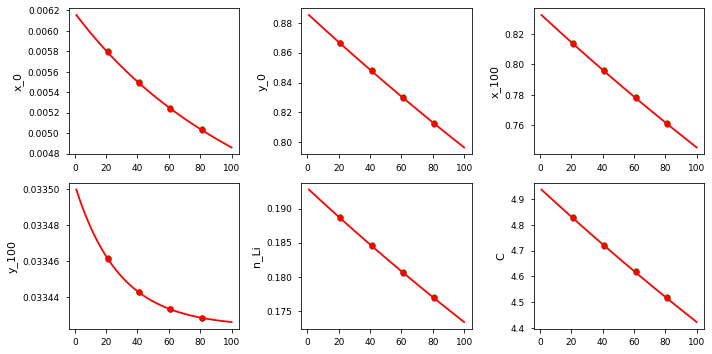

In [23]:
n_cycles_step = 20
long_sol = spm_sol_100
cycle = 0

esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, ax = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax.flat[k].plot(long_sol.summary_variables["Cycle number"], long_sol.summary_variables[name])
    ax.flat[k].set_ylabel(name)

while cycle < len(long_sol.cycles)-n_cycles_step:
    n_Li_cycle = long_sol.cycles[cycle]["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[0] - n_Li_cycle[-1]
    
    n_Li = n_Li_cycle_init - delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    
    cycle += n_cycles_step
    for k, name in enumerate(esoh_vars):
        ax.flat[k].scatter(cycle+1,esoh_sol[name].data[0],color="g")
        ax.flat[k].scatter(cycle+1,long_sol.summary_variables[name][cycle],color="r")
        
fig.tight_layout()

Use extrapolation to initialize next simulation

In [24]:
n_cycles_step = 20
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])

sim_acc = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_acc = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate one cycle
    sol = sim_acc.solve()
    
    n_Li_cycle = sol["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[-1] - n_Li_cycle[0]
    
    n_Li = n_Li_cycle_init + delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    ics = {}
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    for var in sol.all_models[0].initial_conditions:
        if var.name == "X-averaged negative particle concentration":
            ics[var.name] = x_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        elif var.name == "X-averaged positive particle concentration":
            ics[var.name] = y_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        else:
            first = sim_acc.solution.first_state[var.name].data
            last = sim_acc.solution.last_state[var.name].data
            ics[var.name] = first + (last - first) * n_cycles_step
#             ics[var.name] = sim_acc.solution[var.name].data
    sim_acc.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)

    cycle_nums.append(cycle)
    sol_acc.append(sol)
    cycle += n_cycles_step

0


2021-03-21 20:22:51,325 - [NOTICE] simulation.solve(701): Cycle 1/1 (29.275 ms elapsed) --------------------
2021-03-21 20:22:51,326 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:22:51,427 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 20:22:51,503 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:22:51,606 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:22:51,933 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 637.324 ms
2021-03-21 20:22:51,981 - [NOTICE] simulation.solve(701): Cycle 1/1 (32.328 ms elapsed) --------------------
2021-03-21 20:22:51,982 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:22:52,077 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 20:22:52,112 - [NOTICE] simulation.solve(731): Cycle 1/1, s

20


2021-03-21 20:22:52,361 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 411.973 ms
2021-03-21 20:22:52,408 - [NOTICE] simulation.solve(701): Cycle 1/1 (33.198 ms elapsed) --------------------
2021-03-21 20:22:52,408 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:22:52,498 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 20:22:52,528 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:22:52,571 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50


40


2021-03-21 20:22:52,757 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 382.120 ms
2021-03-21 20:22:52,806 - [NOTICE] simulation.solve(701): Cycle 1/1 (35.258 ms elapsed) --------------------
2021-03-21 20:22:52,807 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:22:52,907 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 20:22:52,949 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:22:52,997 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50


60


2021-03-21 20:22:53,738 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 966.700 ms
2021-03-21 20:22:53,801 - [NOTICE] simulation.solve(701): Cycle 1/1 (44.494 ms elapsed) --------------------
2021-03-21 20:22:53,802 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:22:53,915 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 20:22:53,952 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:22:54,000 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50


80


2021-03-21 20:22:54,187 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 430.616 ms


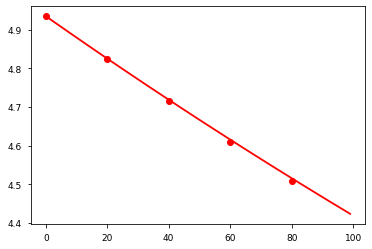

In [25]:
n_Li_acc = [sol.summary_variables["C"] for sol in sol_acc]

fig, ax = plt.subplots()
ax.plot(cycle_nums, n_Li_acc, "ro")
ax.plot(long_sol.summary_variables["C"])
# for k, sol in enumerate(sol_acc):
#     print(sol.summary_variables["n_Li"])
#     print(spm_sol_100.summary_variables["n_Li"][k * n_cycles_step])

2021-03-21 20:23:08,414 - [WARNING] backend_ps._is_transparent(734): The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2021-03-21 20:23:08,415 - [WARNING] backend_ps._is_transparent(734): The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


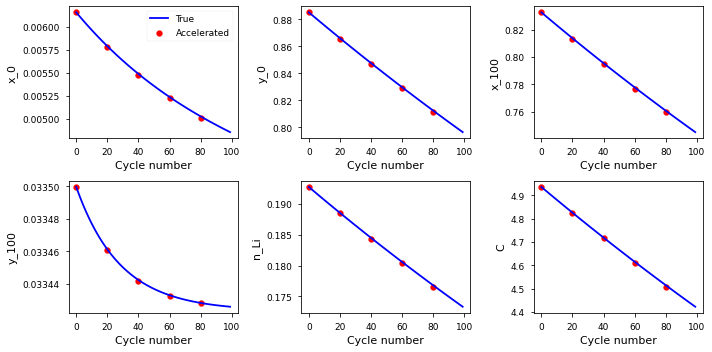

In [26]:
n_Li_acc = [sol.summary_variables["C"] for sol in sol_acc]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name] for sol in sol_acc],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()
fig.savefig(OUTPUT_DIR + "accelerated_sims.eps", dpi=1000)

### Time upscaling

In [27]:
n_cycles_step = 20
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])

sim_upscale = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_upscale = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate one cycle
    sol = sim_upscale.solve()
    
    for var in sol.all_models[0].initial_conditions:
        first = sim_upscale.solution.first_state[var.name].data
        last = sim_upscale.solution.last_state[var.name].data
        ics[var.name] = first + (last - first) * n_cycles_step
    sim_upscale.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)
    print(ics['X-averaged positive particle concentration'])
    cycle_nums.append(cycle)
    sol_upscale.append(sol)
    cycle += n_cycles_step

0


2021-03-21 20:23:23,006 - [NOTICE] simulation.solve(701): Cycle 1/1 (30.138 ms elapsed) --------------------
2021-03-21 20:23:23,007 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:23:23,113 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 20:23:23,198 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 20:23:23,313 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-21 20:23:23,627 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 650.729 ms
2021-03-21 20:23:23,662 - [NOTICE] simulation.solve(701): Cycle 1/1 (29.827 ms elapsed) --------------------
2021-03-21 20:23:23,663 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:23:23,757 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 20:23:23,795 - [NOTICE] simulation.solve(731): Cycle 1/1, s

[[0.08297176]
 [0.0828995 ]
 [0.08271909]
 [0.08243921]
 [0.08206287]
 [0.08159221]
 [0.08102928]
 [0.0803763 ]
 [0.07963569]
 [0.07881015]
 [0.07790261]
 [0.0769163 ]
 [0.07585466]
 [0.07472139]
 [0.07352044]
 [0.07225593]
 [0.07093222]
 [0.06955382]
 [0.06812542]
 [0.06665184]
 [0.06513804]
 [0.06358907]
 [0.06201008]
 [0.06040626]
 [0.05878286]
 [0.05714514]
 [0.05549838]
 [0.0538478 ]
 [0.05219862]
 [0.05055597]]
20


2021-03-21 20:23:24,054 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 422.063 ms
2021-03-21 20:23:24,095 - [NOTICE] simulation.solve(701): Cycle 1/1 (36.631 ms elapsed) --------------------
2021-03-21 20:23:24,096 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 20:23:24,158 - [WARNING] simulation.solve(767): 

	Experiment is infeasible: 'event: Maximum voltage' was triggered during 'Discharge at 1C until 3.0V'. The returned solution only contains the first 0 cycles. Try reducing the current, shortening the time interval, or reducing the period.




[[-0.85795151]
 [-0.85665139]
 [-0.85340538]
 [-0.84836977]
 [-0.84159861]
 [-0.83313028]
 [-0.82300185]
 [-0.81125302]
 [-0.79792753]
 [-0.78307368]
 [-0.76674449]
 [-0.7489976 ]
 [-0.72989523]
 [-0.70950392]
 [-0.68789434]
 [-0.66514097]
 [-0.6413219 ]
 [-0.61651843]
 [-0.5908148 ]
 [-0.56429781]
 [-0.53705654]
 [-0.50918188]
 [-0.48076628]
 [-0.45190329]
 [-0.42268722]
 [-0.39321278]
 [-0.36357464]
 [-0.33386714]
 [-0.30418383]
 [-0.27461717]]
40


IndexError: list index out of range

In [ ]:
sol_fast = sol_upscale
n_Li_acc = [sol.summary_variables["C"] for sol in sol_fast]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name] for sol in sol_fast],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()

It doesn't work because y_100 is much too non-linear, so extrapolating the change gives inaccurate results

### Linear extrapolation

In [ ]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
] * 2)
n_cycles_step = 60

sim_acc_linear = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_acc_linear = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate two cycles
    sol = sim_acc_linear.solve()
    
    n_Li_cycle_init = sol.cycles[-2].first_state["Total lithium in particles [mol]"].data[0]
    n_Li_cycle_mid = sol.cycles[-2].last_state["Total lithium in particles [mol]"].data[0]
    n_Li_cycle_last = sol.cycles[-1].last_state["Total lithium in particles [mol]"].data[0]

    delta_nLi_cycle_0 = n_Li_cycle_mid - n_Li_cycle_init
    delta_nLi_cycle_1 = n_Li_cycle_last - n_Li_cycle_mid
    delta_nLi_cycle_N = delta_nLi_cycle_0 + (delta_nLi_cycle_1 - delta_nLi_cycle_0) * n_cycles_step
    
    # Linear extrapolation and integrate (triangle) to get the total n_li over cycles being stepped
#     delta_nLi_total = delta_nLi_cycle_0 + (n_cycles_step-1) * (delta_nLi_cycle_0 + delta_nLi_cycle_N) / 2
    delta_nLi_total = (
        delta_nLi_cycle_0 * n_cycles_step 
        + 1/2 * (delta_nLi_cycle_1 - delta_nLi_cycle_0) * n_cycles_step * (n_cycles_step + 1)
    )
    n_Li = n_Li_cycle_init + delta_nLi_total

    print(n_Li_cycle_init)
    print(n_Li)
    print(n_Li_cycle_init + n_cycles_step * delta_nLi_cycle_0)
    
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    ics = {}
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    for var in sol.all_models[0].initial_conditions:
        if var.name == "X-averaged negative particle concentration":
            ics[var.name] = x_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        elif var.name == "X-averaged positive particle concentration":
            ics[var.name] = y_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        else:
            first = sim_acc_linear.solution.first_state[var.name].data
            last = sim_acc_linear.solution.last_state[var.name].data
            ics[var.name] = first + (last - first) * n_cycles_step
#             ics[var.name] = sim_acc.solution[var.name].data
    sim_acc_linear.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)

    cycle_nums.append(cycle)
    sol_acc_linear.append(sol)
    cycle += n_cycles_step

In [ ]:
len(cycle_nums)

In [ ]:
sol_fast = sol_acc_linear
n_Li_acc = [sol.summary_variables["C"] for sol in sol_fast]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name][0] for sol in sol_fast],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()
fig.savefig(OUTPUT_DIR + "accelerated_sims_linear.eps", dpi=1000)